The dataset used in this analysis is courtesy of Kaggle contributor EduardoMagalhãesOliveira, and the original dataset can be found here: https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# For handling outliers
from scipy import stats

# For SHAP values
!pip install shap
import shap

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define the path to dataset
dataset_path = ### REDACTED ###

# Load the dataset
df = pd.read_csv(dataset_path, parse_dates=['date'])
df.head()


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,0.552,0.1698,3019.0,557.4,395.7,10.0664,1.74,249.2,253.2,...,250.8,457.3,432.9,424.9,443.5,502.2,446.3,523.3,0.6691,0.0131
1,2017-03-10 01:00:20,0.552,0.1698,3024.0,563.9,397.3,10.0672,1.74,249.7,250.5,...,248.9,451.8,429.5,432.9,448.0,496.3,445.9,498.0,0.6691,0.0131
2,2017-03-10 01:00:40,0.552,0.1698,3043.0,568.0,399.6,10.0680,1.74,249.7,247.8,...,248.0,451.2,468.9,434.6,449.6,484.4,447.8,458.5,0.6691,0.0131
3,2017-03-10 01:01:00,0.552,0.1698,3047.0,568.6,397.9,10.0689,1.74,249.9,254.4,...,251.1,452.4,458.1,442.8,446.2,471.4,437.6,427.6,0.6691,0.0131
4,2017-03-10 01:01:20,0.552,0.1698,3033.0,558.1,400.2,10.0697,1.74,250.2,252.1,...,248.9,452.4,452.9,450.5,453.6,462.5,443.6,425.6,0.6691,0.0131


In [4]:
# Display basic information about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          737453 non-null  datetime64[ns]
 1   % Iron Feed                   737453 non-null  float64       
 2   % Silica Feed                 737453 non-null  float64       
 3   Starch Flow                   737453 non-null  float64       
 4   Amina Flow                    737453 non-null  float64       
 5   Ore Pulp Flow                 737453 non-null  float64       
 6   Ore Pulp pH                   737453 non-null  float64       
 7   Ore Pulp Density              737453 non-null  float64       
 8   Flotation Column 01 Air Flow  737453 non-null  float64       
 9   Flotation Column 02 Air Flow  737453 non-null  float64       
 10  Flotation Column 03 Air Flow  737453 non-null  float64       
 11  Flotation Col

In [5]:
# Get statistical summary
df.describe()


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,737453,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,...,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000
mean,2017-06-16 03:57:12.639966720,0.562947,0.146517,2868.688003,488.095123,397.528829,9.767639,1.680380,280.102112,277.110465,...,290.705443,520.194516,522.599969,531.303122,420.271505,425.202228,429.891461,420.971675,0.650501,0.023268
min,2017-03-10 01:00:00,0.427400,0.013100,0.002000,241.600000,376.200000,8.753340,1.519820,175.500000,175.100000,...,185.900000,149.200000,210.700000,126.200000,162.200000,166.900000,155.800000,175.300000,0.620500,0.006000
25%,2017-05-04 23:16:40,0.526700,0.089400,2076.000000,431.700000,394.200000,9.527360,1.647310,250.200000,250.400000,...,256.300000,416.900000,441.800000,411.300000,356.600000,357.600000,358.400000,356.700000,0.643700,0.014400
50%,2017-06-16 15:31:00,0.560800,0.138500,3018.000000,504.300000,399.200000,9.798100,1.697600,299.300000,296.200000,...,299.000000,491.800000,495.900000,494.300000,411.900000,408.700000,424.600000,411.000000,0.652100,0.020000
75%,2017-07-29 07:45:20,0.597200,0.196000,3727.000000,553.200000,402.900000,10.038000,1.728330,300.100000,300.600000,...,301.900000,594.100000,595.400000,601.200000,485.500000,484.300000,492.600000,476.400000,0.658600,0.030100
max,2017-09-09 23:59:40,0.657800,0.334000,6300.000000,739.500000,418.600000,10.808100,1.853250,373.800000,375.900000,...,371.500000,862.200000,828.900000,886.800000,680.300000,675.600000,698.800000,659.900000,0.680100,0.055300
std,NaN,0.051577,0.068074,1215.122177,91.230568,9.699823,0.387007,0.069249,29.621535,30.149402,...,28.670412,131.014744,128.165016,150.842055,91.794449,84.535660,89.862255,84.891538,0.011186,0.011256


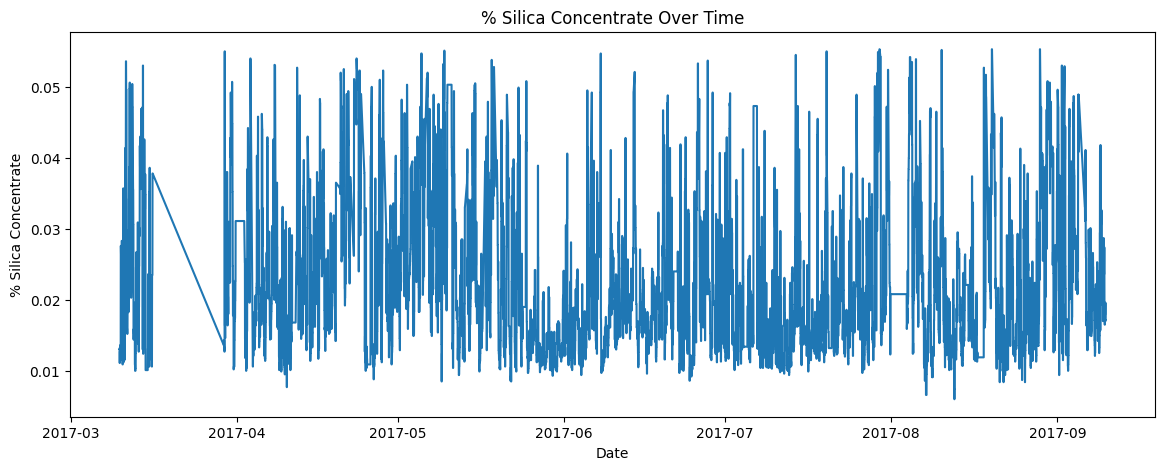

In [6]:
plt.figure(figsize=(14, 5))
plt.plot(df['date'], df['% Silica Concentrate'])
plt.title('% Silica Concentrate Over Time')
plt.xlabel('Date')
plt.ylabel('% Silica Concentrate')
plt.show()


In [7]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Impute missing values using forward fill method
df.fillna(method='ffill', inplace=True)

# Verify that there are no missing values left
print("\nAfter imputation:")
print(df.isnull().sum())


Missing values in each column:
date                            0
% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
dtype: int64

After imputation:
date                            0
% Iron Feed                     0
% Silica Feed                   0
Starch Flow        

In [8]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate Z-scores
z_scores = stats.zscore(df[numerical_cols])

# Set a threshold for Z-score
threshold = 3

# Identify outliers
outliers = (np.abs(z_scores) > threshold)

# Remove outliers
df = df[(~outliers).all(axis=1)]


In [9]:
# Features to be scaled
features = df.drop(['date', '% Silica Concentrate', '% Iron Concentrate'], axis=1)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the features
scaled_features = scaler.fit_transform(features)

# Convert back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Add the target variable and date back to the DataFrame
scaled_df['% Silica Concentrate'] = df['% Silica Concentrate'].values
scaled_df['date'] = df['date'].values


In [10]:
# Sort the DataFrame by date
scaled_df.sort_values('date', inplace=True)

# Define the size of the training set (e.g., 80%)
train_size = int(len(scaled_df) * 0.8)

# Split the data
train = scaled_df.iloc[:train_size]
test = scaled_df.iloc[train_size:]

# Separate features and target variable
X_train = train.drop(['% Silica Concentrate', 'date'], axis=1)
y_train = train['% Silica Concentrate']
X_test = test.drop(['% Silica Concentrate', 'date'], axis=1)
y_test = test['% Silica Concentrate']

# For plotting purposes, keep the date
test_dates = test['date']


**Linear Regression**

Linear Regression is a fundamental statistical method used to model the linear relationship between a dependent variable and one or more independent variables. In this project, we employ linear regression as a baseline model to predict the % Silica Concentrate based on various operational parameters in the mineral processing plant. By fitting a linear equation to the observed data, we aim to understand the direct impact of each input feature on the target variable. This approach provides initial insights into which factors are most influential and sets the stage for more complex modeling techniques.

In [11]:
# Initialize the model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)


LinearRegression()

In [12]:
# Make predictions
lr_preds = lr_model.predict(X_test)

# Evaluate the model
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))

print(f'Linear Regression MAE: {lr_mae:.4f}')
print(f'Linear Regression RMSE: {lr_rmse:.4f}')


Linear Regression MAE: 0.0089
Linear Regression RMSE: 0.0111


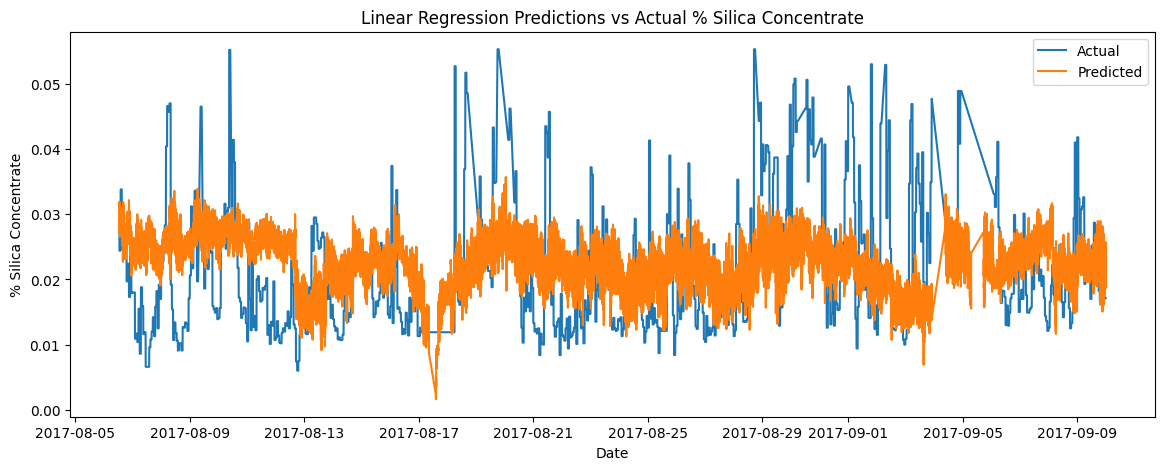

In [13]:
# Time Series Plot
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test.values, label='Actual')
plt.plot(test_dates, lr_preds, label='Predicted')
plt.title('Linear Regression Predictions vs Actual % Silica Concentrate')
plt.xlabel('Date')
plt.ylabel('% Silica Concentrate')
plt.legend()
plt.show()


**Results and Interpretation:**

The linear regression model revealed several key features with significant coefficients, indicating their impact on the % Silica Concentrate. The most positive coefficients were associated with:

* Flotation Column 04 Air Flow
* Amina Flow
* Flotation Columns 5 and 7 Air Flow
* % Silica Feed

From a modeling perspective, these positive coefficients suggest that increases in these variables are linearly associated with an increase in the silica concentration in the output. For a metallurgical engineer, this makes practical sense:

* Flotation Air Flow: Higher air flow in specific flotation columns enhances bubble formation, improving the attachment of silica particles to air bubbles and increasing their recovery in the concentrate.
* Amina Flow: Amina acts as a collector for silica particles. Increased amina dosage improves the hydrophobicity of silica, enhancing its separation from iron minerals.
* % Silica Feed: A higher silica content in the feed naturally leads to a higher potential for silica recovery in the concentrate.

Conversely, the most negative coefficients were linked to:

* Flotation Columns 1 and 3 Air Flow
* Ore Pulp pH
* Starch Flow

Model-wise, negative coefficients indicate that increases in these variables lead to a decrease in the target variable. Metallurgically:

* Flotation Air Flow in Early Columns: Excessive air flow in initial flotation stages may cause turbulence, reducing the selectivity and causing iron minerals to report to the concentrate.
* Ore Pulp pH: Lower pH levels can affect reagent efficacy and mineral surface charges, potentially decreasing silica recovery.
* Starch Flow: Starch is used as a depressant for iron minerals. Increased starch flow might enhance iron depression but could also inadvertently depress silica if not optimized, reducing its recovery.

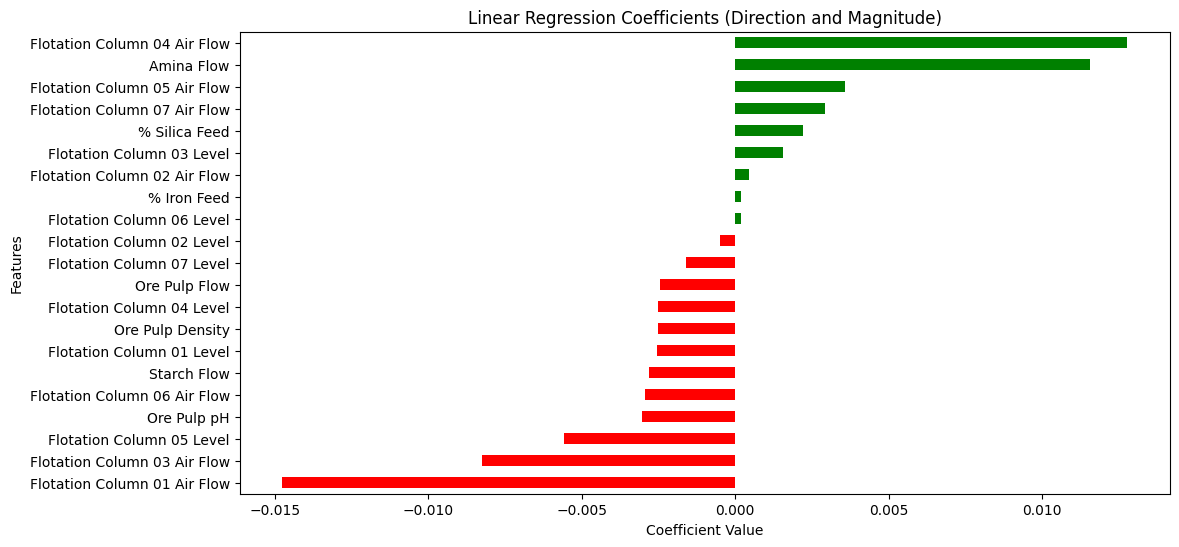

In [14]:
# Get the coefficients of the linear regression model
coefficients = pd.Series(lr_model.coef_, index=X_train.columns)

# Sort coefficients
coefficients = coefficients.sort_values()

# Plot the coefficients with directionality
plt.figure(figsize=(12, 6))
coefficients.plot(kind='barh', color=['red' if c < 0 else 'green' for c in coefficients])
plt.title('Linear Regression Coefficients (Direction and Magnitude)')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


**Random Forest Regression**

Random Forest Regression is an ensemble learning method that builds multiple decision trees and merges their results to improve predictive accuracy and control overfitting. This model captures nonlinear relationships and interactions between variables, making it suitable for complex datasets like those in mineral processing. By analyzing the aggregated decisions of numerous trees, we can gain deeper insights into how different features influence the % Silica Concentrate.

In [15]:
# Adjusted Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=50,       # Reduced number of trees
    max_depth=10,          # Limit the depth of the trees
    min_samples_split=5,   # Increase minimum samples required to split
    n_jobs=-1,             # Use all CPU cores
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=50,
                      n_jobs=-1, random_state=42)

In [16]:
# Make predictions
rf_preds = rf_model.predict(X_test)

# Evaluate the model
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f'Random Forest MAE: {rf_mae:.4f}')
print(f'Random Forest RMSE: {rf_rmse:.4f}')


Random Forest MAE: 0.0096
Random Forest RMSE: 0.0123


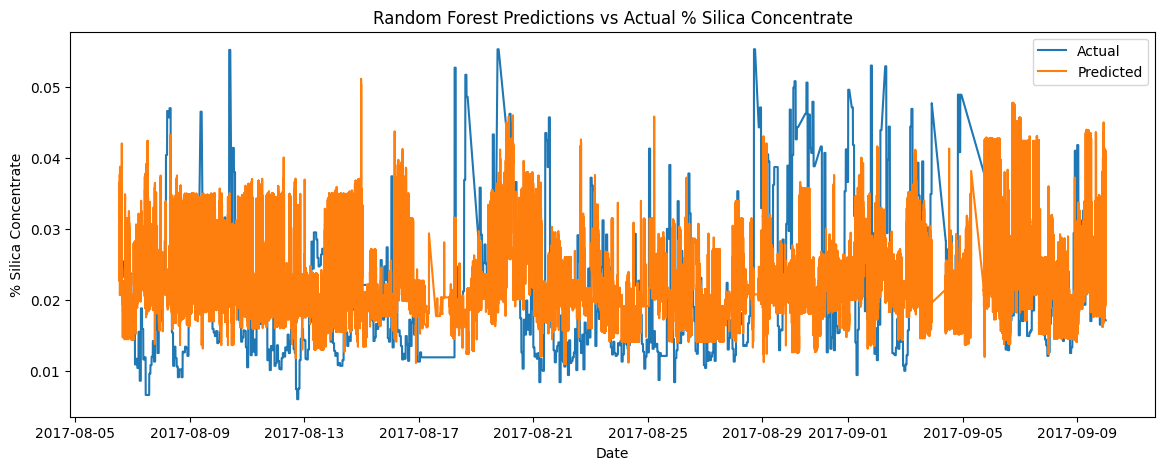

In [17]:
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test.values, label='Actual')
plt.plot(test_dates, rf_preds, label='Predicted')
plt.title('Random Forest Predictions vs Actual % Silica Concentrate')
plt.xlabel('Date')
plt.ylabel('% Silica Concentrate')
plt.legend()
plt.show()


In [18]:
# Initialize the JS visualization code
shap.initjs()

# Create a SHAP explainer
explainer_rf = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values_rf = explainer_rf.shap_values(X_test)


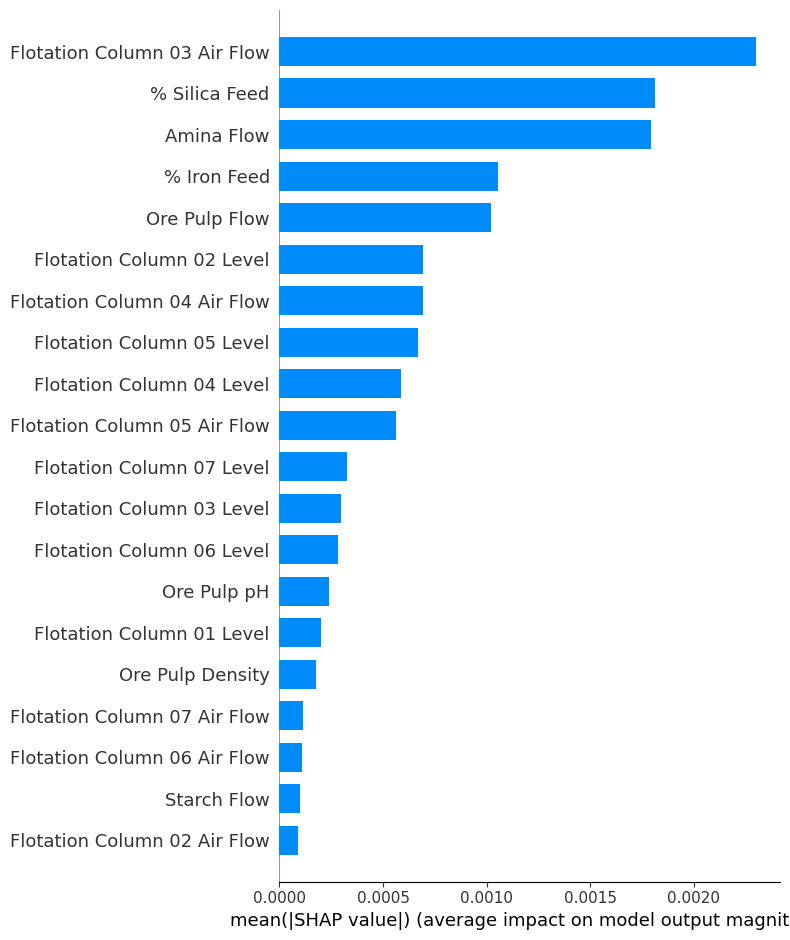

In [19]:
# Plot summary plot
shap.summary_plot(shap_values_rf, X_test, plot_type='bar')


**Results and Interpretation:**

Using SHAP (SHapley Additive exPlanations) values, we interpreted the Random Forest model to understand feature importance and directionality:

* Low Flotation Column 3 Air Flow: Associated with higher silica concentration. Metallurgically, reducing air flow may enhance selectivity by minimizing turbulence, allowing silica particles to attach to bubbles more efficiently.
* % Silica Feed: A higher silica content in the feed consistently led to higher silica in the concentrate, underscoring the feed's composition as a critical factor.
* Amina Flow: Higher amina flow increased the silica concentration, aligning with its role as a collector enhancing silica flotation.
* Ore Pulp Flow: Lower pulp flow rates were linked to higher silica concentration. Slower pulp flow may provide increased residence time, improving the separation efficiency.

From a modeling perspective, the SHAP values highlight both the importance and the impact direction of features. For metallurgical engineers, these insights suggest that careful control of air flow rates, reagent dosages, and pulp flow can optimize the flotation process to maximize silica recovery.

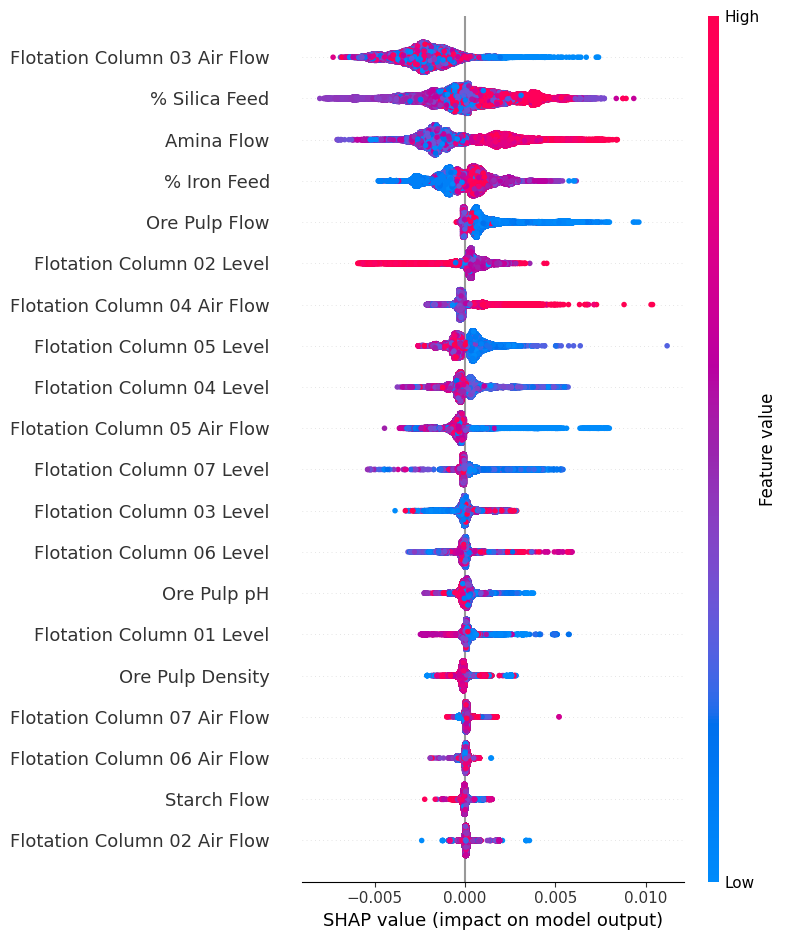

In [20]:
# Summary plot with directionality
shap.summary_plot(shap_values_rf, X_test)


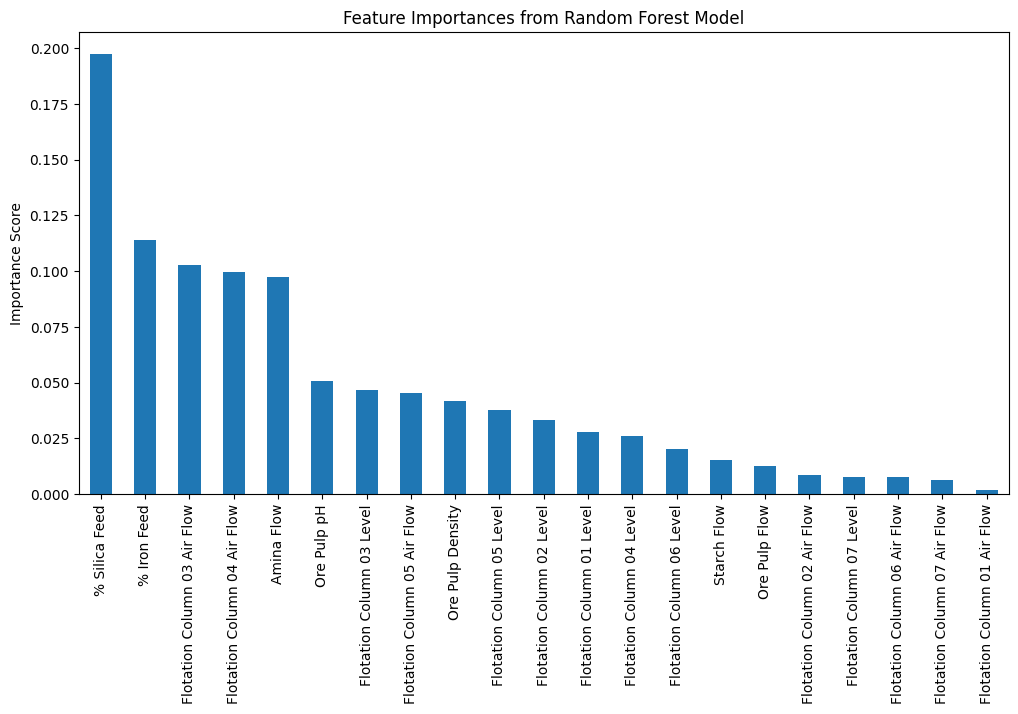

In [21]:
# Get feature importances
importances_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances_rf = importances_rf.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
importances_rf.plot(kind='bar')
plt.title('Feature Importances from Random Forest Model')
plt.ylabel('Importance Score')
plt.show()


**XGBoost Regression**

XGBoost is an advanced gradient boosting technique that excels in handling structured data and capturing complex feature interactions. It builds additive models in a forward stage-wise fashion, allowing for the optimization of arbitrary differentiable loss functions. In our analysis, XGBoost helps in modeling the intricate relationships between operational parameters and the % Silica Concentrate.

In [22]:
# Install XGBoost if not already installed
!pip install xgboost


In [23]:
from xgboost import XGBRegressor


In [24]:
# Initialize the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [25]:
# Make predictions
xgb_preds = xgb_model.predict(X_test)

# Evaluate the model
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

print(f'XGBoost MAE: {xgb_mae:.4f}')
print(f'XGBoost RMSE: {xgb_rmse:.4f}')


XGBoost MAE: 0.0097
XGBoost RMSE: 0.0120


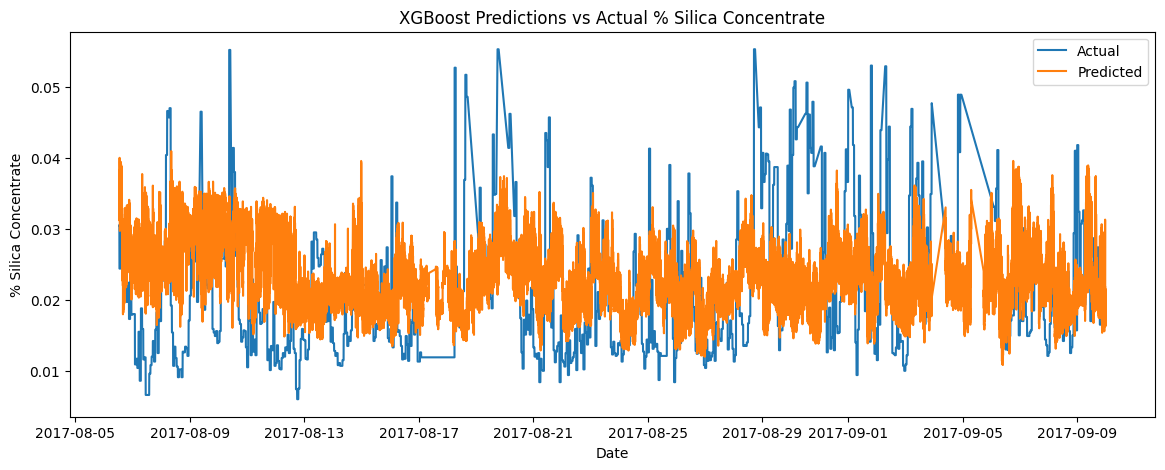

In [26]:
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test.values, label='Actual')
plt.plot(test_dates, xgb_preds, label='Predicted')
plt.title('XGBoost Predictions vs Actual % Silica Concentrate')
plt.xlabel('Date')
plt.ylabel('% Silica Concentrate')
plt.legend()
plt.show()


In [27]:
# Create a SHAP explainer
explainer_xgb = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values_xgb = explainer_xgb.shap_values(X_test)


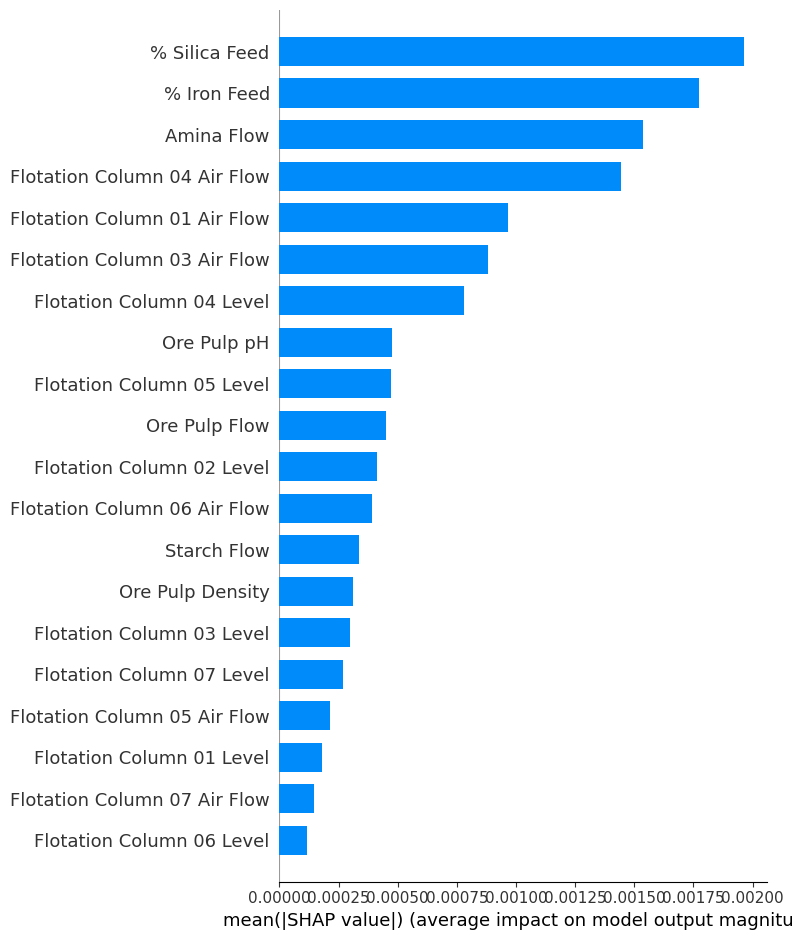

In [28]:
# Plot summary plot
shap.summary_plot(shap_values_xgb, X_test, plot_type='bar')


**Results and Interpretation:**

The SHAP analysis for the XGBoost model revealed key features influencing the target variable:

* % Silica Feed: High values led to higher silica concentration in the concentrate, reaffirming the significance of feed quality.
* Amina Flow: Similar to the Random Forest results, increased amina flow positively impacted silica recovery.
* % Iron Feed: The relationship here was more complex. Both low and high iron feed percentages were associated with high silica concentrations, suggesting interactions between iron content and other operational parameters.
From a modeling standpoint, XGBoost effectively captured nonlinearities and interactions that linear models might miss. For metallurgical engineers, these findings emphasize the need to consider the interplay between feed composition and reagent dosages. The complex relationship with iron feed content suggests that iron minerals might affect the flotation behavior of silica, possibly through surface chemistry interactions or changes in pulp rheology.



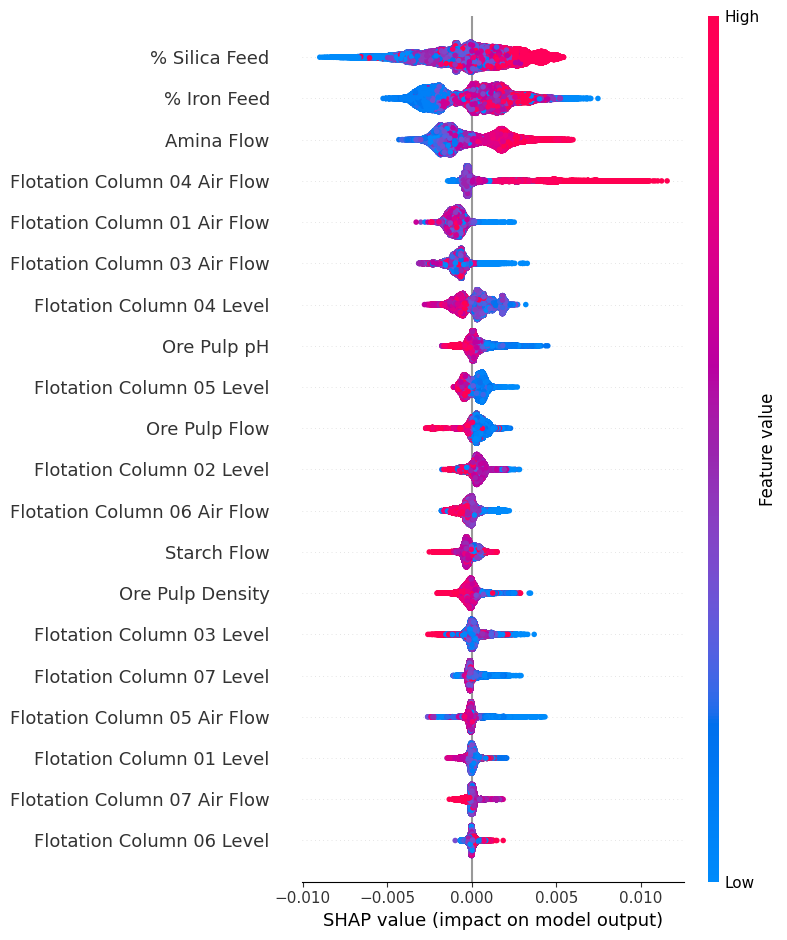

In [29]:
# Summary plot with directionality
shap.summary_plot(shap_values_xgb, X_test)


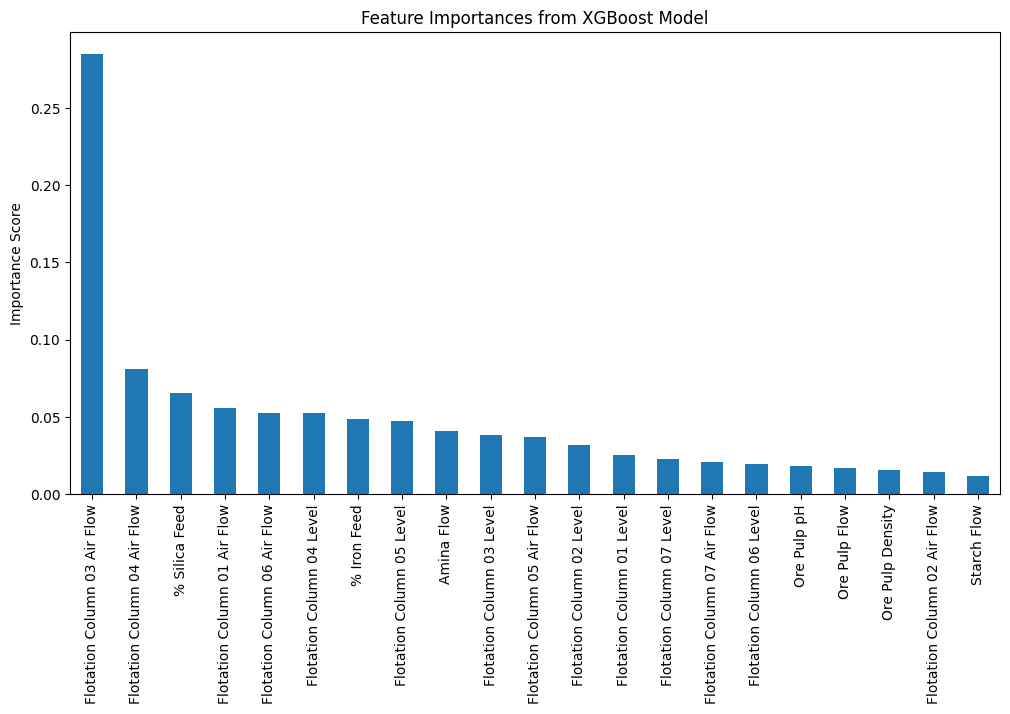

In [30]:
# Get feature importances
importances_xgb = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
importances_xgb = importances_xgb.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
importances_xgb.plot(kind='bar')
plt.title('Feature Importances from XGBoost Model')
plt.ylabel('Importance Score')
plt.show()


In [54]:
# Create a DataFrame to compare the models
performance = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [lr_mae, rf_mae, xgb_mae],
    'RMSE': [lr_rmse, rf_rmse, xgb_rmse]
})

performance


,Model,MAE,RMSE
0,Linear Regression,0.008872,0.011119
1,Random Forest,0.009615,0.012259
2,XGBoost,0.009655,0.011964


**General Observations**
Across the models, certain features consistently emerged as significant:

* High % Silica Feed: Directly contributes to higher silica concentration in the concentrate.
* Amina Flow: Enhances the flotation of silica, increasing its recovery.
* Flotation Column Air Flows: Air flow rates need to be optimized; too high or too low can negatively impact the process.
* % Iron Feed: Exhibits a complex relationship with silica concentration, indicating that iron content influences flotation dynamics.

From both modeling and metallurgical perspectives, these insights are invaluable. They not only improve our predictive capabilities but also guide operational adjustments to optimize the flotation process. By understanding which parameters have the most significant impact and how they affect the outcome, we can make informed decisions to enhance efficiency, reduce costs, and achieve desired concentrate qualities.

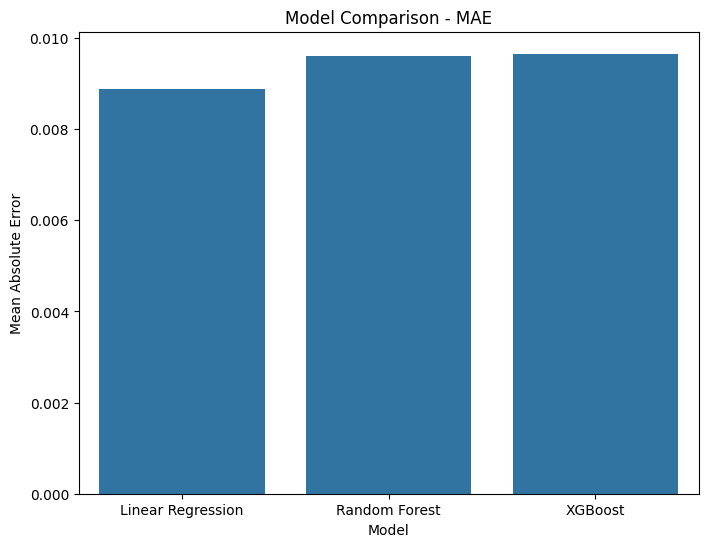

In [55]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MAE', data=performance)
plt.title('Model Comparison - MAE')
plt.ylabel('Mean Absolute Error')
plt.show()


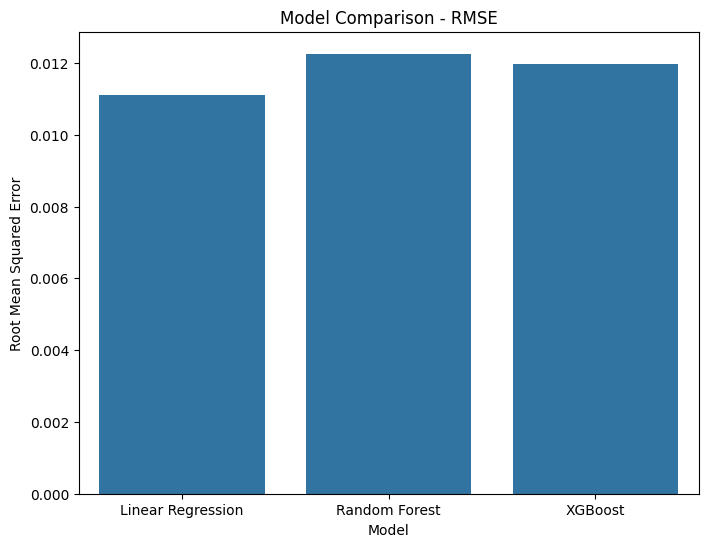

In [56]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='RMSE', data=performance)
plt.title('Model Comparison - RMSE')
plt.ylabel('Root Mean Squared Error')
plt.show()
